In [1]:
from enum import auto, StrEnum
import re

import requests
from requests_cache import CachedSession

from urllib.parse import quote
from urllib.request import urlopen

import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.rcParams["figure.figsize"] = (10, 10)


class Preset(StrEnum):
    duel = auto()
    team = auto()
    ffa = auto()
    all = auto()


preset = Preset.team
season0: bool = True


In [2]:
# Cache the data
def get_data(url: str):
    session = CachedSession("bar_cache", backend="sqlite")
    data = session.get(url).json()
    return data


def get_fresh_data(url: str):
    # print(f"Getting data from {url}")
    session = CachedSession("short_cache", backend="sqlite", expire_after=60)
    data = session.get(url).json()
    return data

In [3]:
# Get user name from user id
def get_user_name(user_id: int):
    name_list = get_data("https://api.bar-rts.com/cached-users")
    user_name = ""
    for user in name_list:
        if user["id"] == user_id:
            user_name = user["username"]
    return user_name

def get_user_id(user_name: str):
    name_list = get_data("https://api.bar-rts.com/cached-users")
    user_id = ""
    for user in name_list:
        if user["username"] == user_name:
            user_id = user["id"]
    return user_id

In [4]:
def process_match_data(match_details_df):
    # Get the winning team and count the number of wins
    match = {}
    matches = []

    for _, game in match_details_df.iterrows():
        # print(game)
        for team in game["AllyTeams"]:
            for player in team["Players"]:
                match = {
                    **match,
                    **{
                        "id": team["id"],
                        "userId": player["userId"],
                        "teamId": player["teamId"],
                        "allyTeamId": player["allyTeamId"],
                        "name": player["name"],
                        "faction": player["faction"],
                        "rank": player["rank"],
                        "skillUncertainty": player["skillUncertainty"],
                        "skill": float(re.sub("[^0123456789\.]", "", player["skill"])),
                        "startPos": player["startPos"],
                        "winningTeam": team["winningTeam"],
                        "Map.fileName": game["Map.fileName"],
                        # + "_"
                        # + str(len(team["Players"]))
                        # + "v"
                        # + str(len(team["Players"])),
                        "Map.scriptName": game["Map.scriptName"],
                        "durationMs": game["durationMs"],
                        "startTime": game["startTime"],
                    },
                }
                matches.append(match)

    matches_df = pd.json_normalize(matches)
    matches_df["startTime"] = pd.to_datetime(matches_df["startTime"])
    return matches_df


# Get match details for each match
def get_match_details(id: str):
    match_details = get_data(f"https://api.bar-rts.com/replays/{id}")

    match_details_df = pd.json_normalize(match_details)
    match_details_df["startTime"] = pd.to_datetime(match_details_df["startTime"])
    return match_details_df

In [5]:
# Get the players replays metadata
def get_match_data(user: str, preset: Preset = Preset.all):
    # Depending on the preset, the API returns different data.json
    # The preset uses the following format: &preset=duel%2Cffa%2Cteam
    # duel%2Cffa%2Cteam is the same as duel,ffa,team

    if preset == Preset.all:
        preset = "&preset=duel&preset=ffa&preset=team"
    else:
        preset = f"&preset={preset.name}"

    uri = f"https://api.bar-rts.com/replays?page=1&limit=9999{preset}&hasBots=false&endedNormally=true&players="

    data = get_data(f"{uri}{quote(user)}")

    # Get the winning team and count the number of wins
    matches = []

    for game in data["data"]:
        if game["Map"]["fileName"] is not None:
            matches.append(get_match_details(game["id"]))
            
    matches_df = pd.concat(matches, axis=0)
    return matches_df

In [6]:
matches_details_df = process_match_data(get_match_data("furyhawk"))

In [7]:
matches_details_df

,id,userId,teamId,allyTeamId,name,faction,rank,skillUncertainty,skill,winningTeam,Map.fileName,Map.scriptName,durationMs,startTime,startPos.x,startPos.y,startPos.z
0,715941,4040,5,715941,Karunel,Armada,3,3.0,26.74,False,flats_and_forests_v2.1,Flats and Forests v2.1,1004467,2023-07-06 13:26:31+00:00,11646.758789,217.387939,3440.973145
1,715941,101939,4,715941,Litschi,Armada,5,3.0,33.98,False,flats_and_forests_v2.1,Flats and Forests v2.1,1004467,2023-07-06 13:26:31+00:00,10197.106445,207.090332,7777.133789
2,715941,1256,2,715941,sneyed,Armada,5,3.0,38.58,False,flats_and_forests_v2.1,Flats and Forests v2.1,1004467,2023-07-06 13:26:31+00:00,11631.319336,224.760742,8888.593750
3,715941,53682,3,715941,fiddler112,Cortex,5,3.0,35.35,False,flats_and_forests_v2.1,Flats and Forests v2.1,1004467,2023-07-06 13:26:31+00:00,11715.701172,210.979980,11950.851562
4,715941,92112,6,715941,BattleMoose,Armada,3,3.0,25.46,False,flats_and_forests_v2.1,Flats and Forests v2.1,1004467,2023-07-06 13:26:31+00:00,10247.027344,225.524170,1518.017456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2081,512454,57139,11,512454,[DSM]UnInstallLyf,Cortex,2,3.0,18.10,True,all_that_glitters_1.2,All That Glitters v1.2,1777500,2023-05-01 08:58:22+00:00,1167.000000,193.704346,602.000000
2082,512454,40640,12,512454,DSA,Cortex,3,3.0,17.39,True,all_that_glitters_1.2,All That Glitters v1.2,1777500,2023-05-01 08:58:22+00:00,4387.000000,193.763672,2203.000000
2083,512454,57580,13,512454,Rastabortionist,Cortex,0,3.0,15.16,True,all_that_glitters_1.2,All That Glitters v1.2,1777500,2023-05-01 08:58:22+00:00,3253.000000,194.605225,2316.000000
2084,512454,94078,14,512454,SentoN,Armada,0,3.0,12.72,True,all_that_glitters_1.2,All That Glitters v1.2,1777500,2023-05-01 08:58:22+00:00,1079.191772,200.370239,2367.832031


In [8]:
# Get the win rate for each map
def get_win_rate(user: str, min_games: int = 5, season0: bool = True):
    
    df = process_match_data(get_match_data(user, preset))
    if season0:
        df = df[df["startTime"] >= "2023-06-01"]
    win_rate = (
        df.query(f"userId == {get_user_id(user)}")
        .groupby(["Map.fileName"])
        .agg({"winningTeam": ["mean", "count"]})["winningTeam"]
        .query(f"count > {str(min_games)}")
        .sort_values([("mean"), ("count")], ascending=True)
    )
    return win_rate

In [9]:
# Set the x axis minor locator to 5 and major locator to 10
# Set the y axis to the map name
def plot_win_rate(user: str, min_games: int = 5, season0: bool = True):
    win_rate = get_win_rate(user, min_games, season0)
    if win_rate.empty:
        print(f"{user} has not played enough games")
        return

    # Get overall win rate
    overall_win_rate = win_rate["mean"].mean()
    # Get total number of games
    total_games = win_rate["count"].sum()

    fig, (ax1, ax2) = plt.subplots(1, 2, sharey="all", figsize=(12, 6))

    bars = ax1.barh(
        y=win_rate.index,
        width=win_rate["mean"],
        alpha=0.75,
    )
    ax1.bar_label(bars, fmt="{:.0%}", label_type="center")
    ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.grid(which="minor", axis="x", linestyle="--")
    ax1.grid(which="major", axis="x", linestyle="-")
    ax1.set_xlabel("Winning %")
    ax1.set_ylabel("Map")
    ax1.set_xlim(0, 1)
    ax1.set_title(f"[{preset.name} games]{user} Winning {overall_win_rate:.0%} by Map")

    ax1.set_axisbelow(True)

    bars = ax2.barh(
        y=win_rate.index,
        width=win_rate["count"],
        alpha=0.75,
    )

    ax2.bar_label(bars, label_type="center")
    ax2.xaxis.set_minor_locator(ticker.MultipleLocator(5))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.grid(which="minor", axis="x", linestyle="--")
    ax2.grid(which="major", axis="x", linestyle="-")
    ax2.set_xlabel("Games")
    ax2.set_title(f"{user} {total_games} games by Map")

    plt.subplots_adjust(wspace=0, hspace=0)

    return fig

In [10]:
get_win_rate("furyhawk")

,mean,count
Map.fileName,,
dsdr_4.1,0.75,8


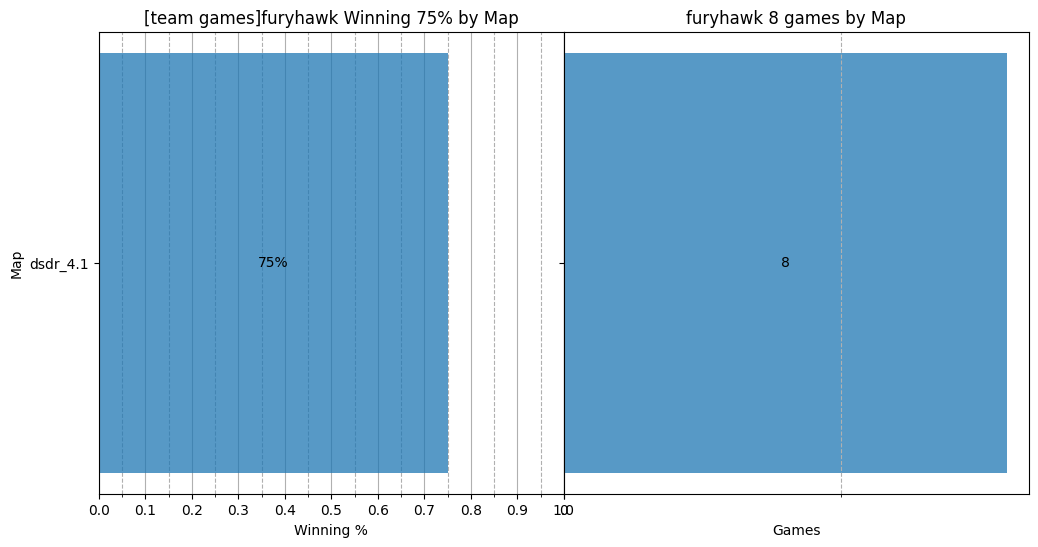

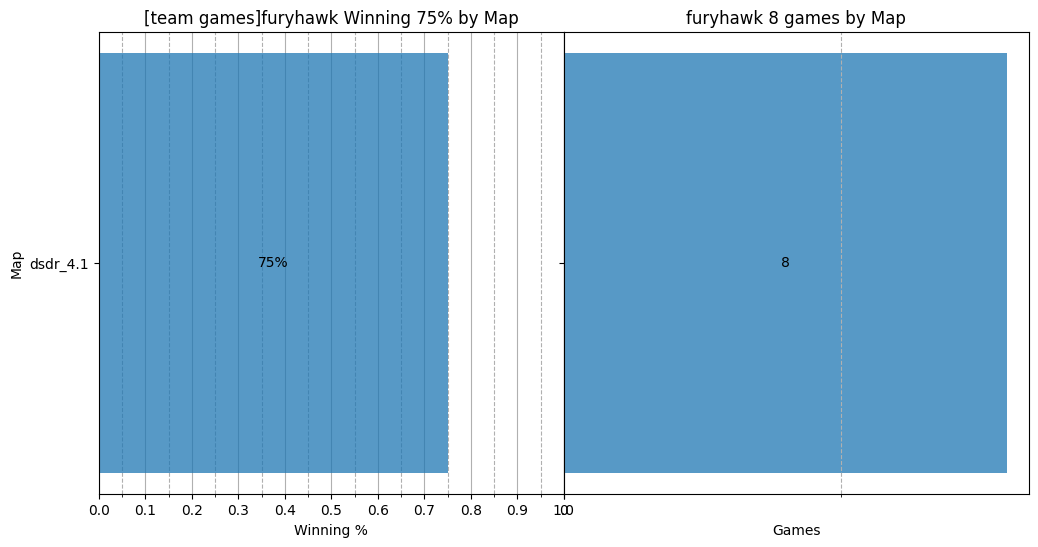

In [11]:
plot_win_rate("furyhawk")

In [12]:
df = process_match_data(get_match_data("furyhawk", preset))
if season0:
    df = df[df["startTime"] >= "2023-06-01"]

    

In [13]:
df

,id,userId,teamId,allyTeamId,name,faction,rank,skillUncertainty,skill,winningTeam,Map.fileName,Map.scriptName,durationMs,startTime,startPos.x,startPos.y,startPos.z
0,715941,4040,5,715941,Karunel,Armada,3,3.0,26.74,False,flats_and_forests_v2.1,Flats and Forests v2.1,1004467,2023-07-06 13:26:31+00:00,11646.758789,217.387939,3440.973145
1,715941,101939,4,715941,Litschi,Armada,5,3.0,33.98,False,flats_and_forests_v2.1,Flats and Forests v2.1,1004467,2023-07-06 13:26:31+00:00,10197.106445,207.090332,7777.133789
2,715941,1256,2,715941,sneyed,Armada,5,3.0,38.58,False,flats_and_forests_v2.1,Flats and Forests v2.1,1004467,2023-07-06 13:26:31+00:00,11631.319336,224.760742,8888.593750
3,715941,53682,3,715941,fiddler112,Cortex,5,3.0,35.35,False,flats_and_forests_v2.1,Flats and Forests v2.1,1004467,2023-07-06 13:26:31+00:00,11715.701172,210.979980,11950.851562
4,715941,92112,6,715941,BattleMoose,Armada,3,3.0,25.46,False,flats_and_forests_v2.1,Flats and Forests v2.1,1004467,2023-07-06 13:26:31+00:00,10247.027344,225.524170,1518.017456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722,616367,96033,12,616367,lolfindkeinnamen,Cortex,2,3.0,16.17,True,supreme_strait_v1.4,Supreme Strait v1.4,2066500,2023-06-01 14:28:39+00:00,4535.524902,59.813599,7434.944824
723,616367,83880,13,616367,Ambassador,Armada,3,3.0,14.79,True,supreme_strait_v1.4,Supreme Strait v1.4,2066500,2023-06-01 14:28:39+00:00,3944.423584,62.832031,9278.013672
724,616367,88793,10,616367,ThePasst,Armada,3,3.0,18.00,True,supreme_strait_v1.4,Supreme Strait v1.4,2066500,2023-06-01 14:28:39+00:00,972.909546,265.818604,10482.109375
725,616367,19953,9,616367,PaniniPie,Cortex,5,3.0,20.45,True,supreme_strait_v1.4,Supreme Strait v1.4,2066500,2023-06-01 14:28:39+00:00,4863.265137,55.085083,8604.011719


In [14]:
# Get allyTeamId of userId



(
    df.query(f"userId == {get_user_id('furyhawk')}")
    .groupby(["faction"])
    .agg({"winningTeam": ["mean", "count"]}) 
    
    # .query(f"count > {str(5)}")
    # .sort_values([("mean"), ("count")], ascending=True)
)

winningTeam      
               mean count
faction                  
Armada     0.581395    43
Cortex     1.000000     1

In [15]:
team_winrate = (
    df.groupby(  # .query(f"userId == {get_user_id('furyhawk')}")
        ["allyTeamId", "userId"]
    ).agg({"winningTeam": ["mean", "count"]})
    # .query(f"count > {str(5)}")
    # .sort_values([("mean"), ("count")], ascending=True)
)

In [16]:
team_winrate

winningTeam      
                         mean count
allyTeamId userId                  
616367     19953          1.0     1
           48295          1.0     1
           81893          1.0     1
           83880          1.0     1
           86458          1.0     1
...                       ...   ...
715941     8202           0.0     1
           53682          0.0     1
           92112          0.0     1
           101939         0.0     1
           116739         0.0     1

[727 rows x 2 columns]

In [17]:
# From team_winrate, get the allyTeamId of the user

team_ally_id = team_winrate.query(f"userId == {get_user_id('furyhawk')}").index.unique(level='allyTeamId')


In [18]:
team_ally_id

Index([616368, 616448, 618891, 619031, 621263, 624391, 624612, 625201, 625809,
       634699, 636952, 637063, 637171, 637254, 643421, 650347, 650434, 650669,
       650722, 650773, 661855, 661932, 668434, 668489, 672706, 672803, 675547,
       678271, 680605, 682820, 682863, 683007, 683056, 683270, 693750, 693775,
       693871, 696222, 697659, 700494, 700739, 704685, 715664, 715940],
      dtype='int64', name='allyTeamId')

In [19]:
teams_df = df[df['allyTeamId'].isin(team_ally_id)]

In [20]:
teams_df.groupby(["name"]).agg({"winningTeam": ["mean", "count"]})["winningTeam"].sort_values([("mean"), ("count")], ascending=False).head(5)

,mean,count
name,,
EmperorGlass,1.0,4
Raikoh,1.0,3
SadPanda,1.0,3
Analogue,1.0,2
Desker,1.0,2


In [21]:
get_user_name(78769)

'Raikoh'

In [22]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-07-09'

In [23]:
data={'data': [{'id': 1,} ]}

In [24]:
if hasattr(data, 'data'):
    print('no')

In [25]:
get_data("https://api.bar-rts.com/battles") 

[{'battleId': 2900,
  'founder': {'username': '[teh]cluster1[06]',
   'userId': 2451,
   'country': 'HU',
   'status': {'ingame': True,
    'away': False,
    'rank': 0,
    'moderator': False,
    'bot': True}},
  'game': 'Beyond All Reason test-23575-aeb64bd',
  'ip': '85.238.68.44',
  'port': 53206,
  'locked': False,
  'map': 'Rosetta 1.4',
  'mapHash': -1558067481,
  'maxPlayers': 16,
  'passworded': False,
  'rank': 0,
  'title': 'EU -  06',
  'players': [{'username': 'MomsBoyToy',
    'userId': 4994,
    'country': 'US',
    'status': {'ingame': True,
     'away': False,
     'rank': 6,
     'moderator': False,
     'bot': False},
    'lobbyReady': 'Yes',
    'skill': '[56.04 ??]',
    'teamId': 9,
    'gameReady': 'No',
    'gameStatus': 'Timeouted',
    'joinedGameAfterStart': False},
   {'username': '[TZN]Clyret',
    'userId': 13160,
    'country': '??',
    'status': {'ingame': True,
     'away': False,
     'rank': 6,
     'moderator': False,
     'bot': False},
    'skill

In [26]:
for battle in get_data("https://api.bar-rts.com/battles"):
    print(battle)

{'battleId': 2900, 'founder': {'username': '[teh]cluster1[06]', 'userId': 2451, 'country': 'HU', 'status': {'ingame': True, 'away': False, 'rank': 0, 'moderator': False, 'bot': True}}, 'game': 'Beyond All Reason test-23575-aeb64bd', 'ip': '85.238.68.44', 'port': 53206, 'locked': False, 'map': 'Rosetta 1.4', 'mapHash': -1558067481, 'maxPlayers': 16, 'passworded': False, 'rank': 0, 'title': 'EU -  06', 'players': [{'username': 'MomsBoyToy', 'userId': 4994, 'country': 'US', 'status': {'ingame': True, 'away': False, 'rank': 6, 'moderator': False, 'bot': False}, 'lobbyReady': 'Yes', 'skill': '[56.04 ??]', 'teamId': 9, 'gameReady': 'No', 'gameStatus': 'Timeouted', 'joinedGameAfterStart': False}, {'username': '[TZN]Clyret', 'userId': 13160, 'country': '??', 'status': {'ingame': True, 'away': False, 'rank': 6, 'moderator': False, 'bot': False}, 'skill': '[58.8 ???]', 'clan': ':1:', 'gameReady': 'No', 'gameStatus': 'Timeouted', 'joinedGameAfterStart': False}, {'username': 'I_AM_MEGATRON', 'user

In [27]:
battles_json = get_fresh_data("https://api.bar-rts.com/battles")
battles_df = pd.json_normalize(battles_json)

In [28]:
battles_df

,battleId,game,ip,port,locked,map,mapHash,maxPlayers,passworded,rank,...,gameTime,mapFileName,founder.username,founder.userId,founder.country,founder.status.ingame,founder.status.away,founder.status.rank,founder.status.moderator,founder.status.bot
0,2900,Beyond All Reason test-23575-aeb64bd,85.238.68.44,53206,False,Jade Empress 1.0,-651197412,16,False,0,...,735.0,jade_empress_1.0,[teh]cluster1[06],2451,HU,False,False,0,False,True
1,2263,Beyond All Reason test-23575-aeb64bd,135.125.232.13,53200,False,Supreme Strait v1.4,-149743136,16,False,0,...,119.0,supreme_strait_v1.4,[teh]clusterEU3[00],45659,US,True,False,0,False,True
2,2759,Beyond All Reason test-23575-aeb64bd,85.238.68.44,53200,False,All That Glitters v2.1,-1668217557,16,False,0,...,3588.0,all_that_glitters_v2.1,[teh]cluster1[00],3773,HU,True,False,0,False,True
3,3562,Beyond All Reason test-23575-aeb64bd,135.125.232.13,53206,False,Darkside v3.0,-260439384,16,False,0,...,846.0,darkside_v3.0,[teh]clusterEU3[06],45689,US,True,False,0,False,True
4,1714,Beyond All Reason test-23571-5284434,85.238.68.44,53204,False,Supreme Strait v1.4,-149743136,16,False,0,...,1270.0,supreme_strait_v1.4,[teh]cluster1[04],647,HU,True,False,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,3405,Beyond All Reason test-23575-aeb64bd,135.148.139.38,53214,False,Omega Valley V0.1,1912665715,16,True,0,...,2634.0,omega_valley_v0.1,[teh]clusterUS[14],16450,US,True,False,0,False,True
68,3605,Beyond All Reason test-23575-aeb64bd,207.244.249.133,53203,False,Ditched_V1,1912665715,16,True,0,...,2530.0,Ditched_V1,[teh]clusterUS3[03],67482,US,True,False,0,False,True
69,3523,Beyond All Reason test-23575-aeb64bd,207.244.249.133,53220,False,Darkside v3.0,-260439384,16,True,0,...,1814.0,darkside_v3.0,[teh]clusterUS3[20],67628,US,True,False,0,False,True
70,3474,Beyond All Reason test-23575-aeb64bd,207.244.249.133,53211,False,Flats and Forests v2.1,1584089724,16,True,0,...,533.0,flats_and_forests_v2.1,[teh]clusterUS3[11],67566,US,True,False,0,False,True


In [29]:
# Get the battle with the most spectators .sort_values(by='spectators', ascending=False)

battles_df.head(1)

,battleId,game,ip,port,locked,map,mapHash,maxPlayers,passworded,rank,...,gameTime,mapFileName,founder.username,founder.userId,founder.country,founder.status.ingame,founder.status.away,founder.status.rank,founder.status.moderator,founder.status.bot
0,2900,Beyond All Reason test-23575-aeb64bd,85.238.68.44,53206,False,Jade Empress 1.0,-651197412,16,False,0,...,735.0,jade_empress_1.0,[teh]cluster1[06],2451,HU,False,False,0,False,True


In [30]:
battles_df.head(1)["mapFileName"].values[0]

'jade_empress_1.0'

In [31]:
battle_list = []

for players in battles_df.head(1)["players"]:
    for player in players:
        if "teamId" in player:  # skill userId
            battle_list.append(
                {
                    "teamId": player["teamId"],
                    "username": player["username"],
                    "userId": player["userId"],
                    "skill": float(re.sub("[^0123456789\.]", "", player["skill"])),
                    "gameStatus": player["gameStatus"],
                    "map": battles_df.head(1)["mapFileName"].values[0],
                    "title": battles_df.head(1)["title"].values[0],
                }
            )
            # print(player["username"])
            # print(player["gameStatus"])
            # print(player["teamId"])

In [32]:
battle_list_df = pd.DataFrame(battle_list).sort_values(by="teamId")

In [33]:
battle_list_df

,teamId,username,userId,skill,gameStatus,map,title
4,1,HellsHound,5467,51.94,Spectating,jade_empress_1.0,EU - 06
7,2,MightySheep,2183,42.97,Playing,jade_empress_1.0,EU - 06
15,3,scag,52043,39.18,Disconnected,jade_empress_1.0,EU - 06
5,4,[LOB]Choice,80622,39.13,Not connected,jade_empress_1.0,EU - 06
10,5,markivs,42091,37.64,Spectating,jade_empress_1.0,EU - 06
13,6,sneyed,1256,36.96,Spectating,jade_empress_1.0,EU - 06
11,7,SomberMuse,59676,29.33,Disconnected,jade_empress_1.0,EU - 06
3,8,FNS,23646,27.80,Playing,jade_empress_1.0,EU - 06
8,9,[TZN]Clyret,13160,58.84,Timeouted,jade_empress_1.0,EU - 06
6,10,Daymus,3097,46.46,Playing,jade_empress_1.0,EU - 06


In [34]:
team_size = len(battle_list_df.index)

In [35]:
battle_list_df.head(team_size // 2)

,teamId,username,userId,skill,gameStatus,map,title
4,1,HellsHound,5467,51.94,Spectating,jade_empress_1.0,EU - 06
7,2,MightySheep,2183,42.97,Playing,jade_empress_1.0,EU - 06
15,3,scag,52043,39.18,Disconnected,jade_empress_1.0,EU - 06
5,4,[LOB]Choice,80622,39.13,Not connected,jade_empress_1.0,EU - 06
10,5,markivs,42091,37.64,Spectating,jade_empress_1.0,EU - 06
13,6,sneyed,1256,36.96,Spectating,jade_empress_1.0,EU - 06
11,7,SomberMuse,59676,29.33,Disconnected,jade_empress_1.0,EU - 06
3,8,FNS,23646,27.80,Playing,jade_empress_1.0,EU - 06


In [36]:
battle_list_df.tail(team_size // 2)

,teamId,username,userId,skill,gameStatus,map,title
8,9,[TZN]Clyret,13160,58.84,Timeouted,jade_empress_1.0,EU - 06
6,10,Daymus,3097,46.46,Playing,jade_empress_1.0,EU - 06
1,11,EmperorGlass,24840,38.94,Timeouted,jade_empress_1.0,EU - 06
12,12,Karolson,25282,37.21,Disconnected,jade_empress_1.0,EU - 06
14,13,RebelNode,31861,38.07,Disconnected,jade_empress_1.0,EU - 06
0,14,Nezah,87571,35.26,Timeouted,jade_empress_1.0,EU - 06
9,15,I_AM_MEGATRON,79633,32.20,Timeouted,jade_empress_1.0,EU - 06
2,16,Volshok,44136,27.39,Spectating,jade_empress_1.0,EU - 06


In [37]:
win_rate_df = get_win_rate("furyhawk") # #.query(f"Map.fileName == 'Rosetta1.4_8v8'")

In [38]:
win_rate_df

,mean,count
Map.fileName,,
dsdr_4.1,0.75,8


In [39]:
win_rate_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, dsdr_4.1 to dsdr_4.1
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mean    1 non-null      float64
 1   count   1 non-null      int64  
dtypes: float64(1), int64(1)
memory usage: 24.0+ bytes


In [40]:
df = win_rate_df.reset_index()

In [41]:
df.loc[df["Map.fileName"]=='Rosetta1.4']#.query(f"Map.fileName == 'Rosetta1.4'")

,Map.fileName,mean,count


In [42]:
map = battle_list_df.tail(team_size // 2)["map"].values[0]

In [43]:
df.loc[df["Map.fileName"]==map]#

,Map.fileName,mean,count


In [44]:
df.loc[df["Map.fileName"]==map]#

,Map.fileName,mean,count


In [45]:
team2_df = battle_list_df.tail(team_size // 2)

In [46]:
team2_df

,teamId,username,userId,skill,gameStatus,map,title
8,9,[TZN]Clyret,13160,58.84,Timeouted,jade_empress_1.0,EU - 06
6,10,Daymus,3097,46.46,Playing,jade_empress_1.0,EU - 06
1,11,EmperorGlass,24840,38.94,Timeouted,jade_empress_1.0,EU - 06
12,12,Karolson,25282,37.21,Disconnected,jade_empress_1.0,EU - 06
14,13,RebelNode,31861,38.07,Disconnected,jade_empress_1.0,EU - 06
0,14,Nezah,87571,35.26,Timeouted,jade_empress_1.0,EU - 06
9,15,I_AM_MEGATRON,79633,32.20,Timeouted,jade_empress_1.0,EU - 06
2,16,Volshok,44136,27.39,Spectating,jade_empress_1.0,EU - 06


In [48]:
for _, player in team2_df.iterrows():
    print(player["username"])
    win_rate_user_df = get_win_rate(player["username"])
    # print(win_rate_user_df.loc[win_rate_user_df["Map.fileName"]==map]["win_rate"].values[0])

[TZN]Clyret
